## V4L2 commands
### Take raw images
```
v4l2-ctl --device=/dev/video0 --set-fmt-video=width=2592,height=1944,pixelformat=BA81 --stream-mmap --stream-skip=60 --stream-count=1 --stream-to=capture01.raw --set-parm=15
```
- Make sure the file size
```
root@moment-ff1-8f1a85ab:~# ls -l capture01.raw
-rw-r--r--    1 root     root       5038848 Jul 22 01:30 capture01.raw
```
- Make sure the formmat
```
root@moment-ff1-8f1a85ab:~# v4l2-ctl --get-fmt-video
Format Video Capture:
	Width/Height      : 2592/1944
	Pixel Format      : 'BA81' (8-bit Bayer BGBG/GRGR)
	Field             : None
	Bytes per Line    : 2592
	Size Image        : 5038848
	Colorspace        : sRGB
	Transfer Function : sRGB
	YCbCr/HSV Encoding: ITU-R 601
	Quantization      : Full Range
	Flags             :
```
### Take jpeg images
```
v4l2-ctl --device=/dev/video0 --set-fmt-video=width=2592,height=1944,pixelformat=JPEG --stream-mmap --stream-skip=60 --stream-count=1 --stream-to=capture02.jpg --set-parm=15
```
- Adjust color
```
v4l2-ctl -d /dev/video0 --list-ctrls
v4l2-ctl -d /dev/video0 --get-ctrl=red_balance
v4l2-ctl -d /dev/video0 --set-ctrl=red_balance=1024
```
- Make sure the formmat
```
root@moment-ff1-8f1a85ab:~# v4l2-ctl --get-fmt-video
Format Video Capture:
	Width/Height      : 2592/1944
	Pixel Format      : 'JPEG' (JFIF JPEG)
	Field             : None
	Bytes per Line    : 2592
	Size Image        : 5038848
	Colorspace        : JPEG
	Transfer Function : sRGB
	YCbCr/HSV Encoding: ITU-R 601
	Quantization      : Full Range
	Flags             :
```
## Extract a frame from video
```
ffmpeg -ss 0 -i ~/Downloads/250722015449.mp4 -frames:v 1 -q:v 2 ~/hobbies/process_raw_image/capture03.jpg
```

In [2]:
# Image sizes

### LOW

# width = 640
# height = 480

### HD

# width = 1920
# height = 1080

### 2K

width = 2592
height = 1944

# Bit depth (e.g. 8bpp, 10bpp, 12bpp, 14bpp, 16bpp)
bpp = 8
# bpp = 16

# Number of images to read
n_images = 1



In [3]:
import shutil, os

# Empty the raw_images and dng_images directories
if os.path.exists('raw_images'):
    shutil.rmtree('raw_images')

if os.path.exists('dng_images'):
    shutil.rmtree('dng_images')

os.mkdir('raw_images')
os.mkdir('dng_images')


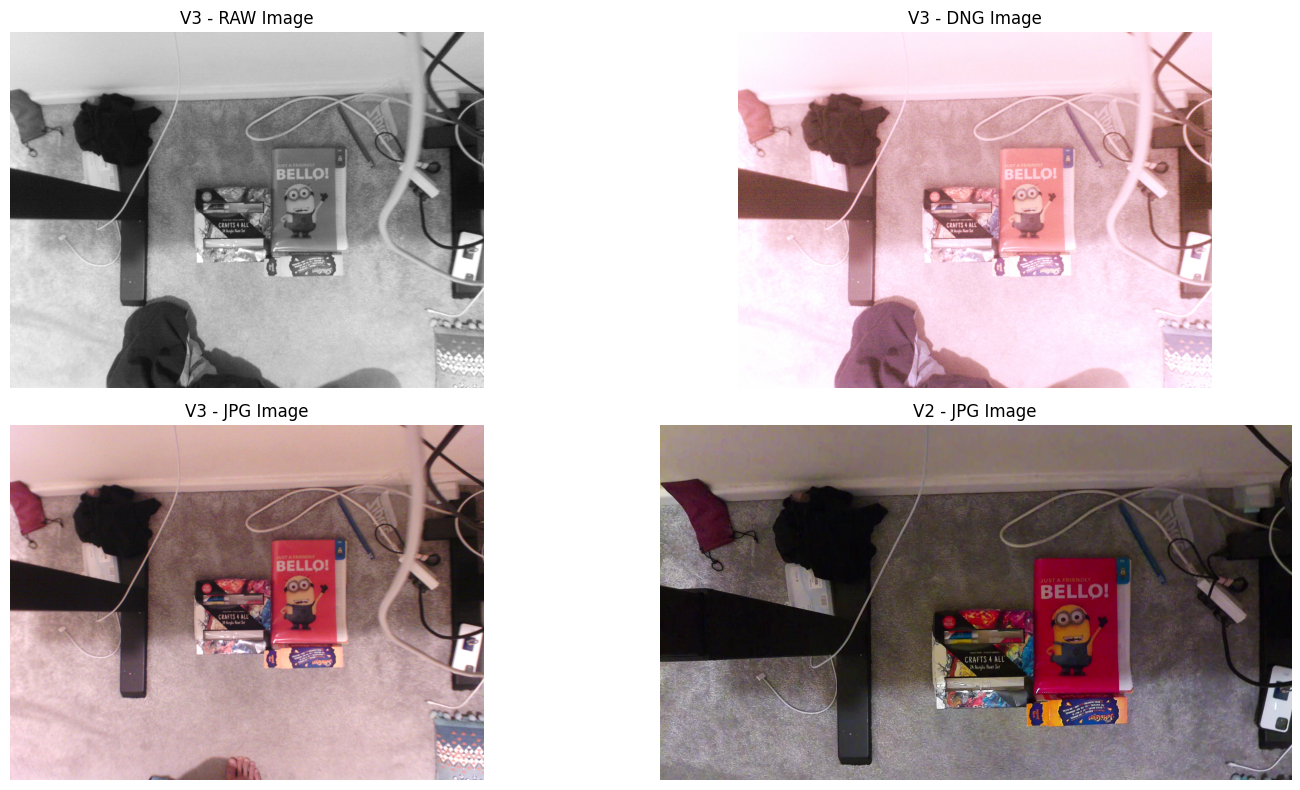

In [28]:
import os
import numpy as np
# from pydng.core import RPICAM2DNG
from pidng.core import RAW2DNG, DNGTags, Tag
from pidng.defs import *
import struct

import rawpy

# Uncomment to zoom & pan within image:
# %matplotlib widget

# Configuration
bayer_pattern = CFAPattern.BGGR
iso_gain = 100
exposure_time = 20e3  # microseconds
numPixels = width*height

for i in range(n_images):

    rawFile = os.path.join('raw_images', f"raw_{i+1}.raw")
    rf = open(rawFile, mode='rb')

    if bpp == 8:
        rawData = struct.unpack("B"*numPixels,rf.read(numPixels))
    elif bpp == 16:
        rawData = struct.unpack("H"*numPixels,rf.read(2*numPixels))
    else:
        raise NotImplemented("Only 8bpp and 16bpp are supported.")

    rawFlatImage = np.zeros(numPixels, dtype=np.uint16)
    rawFlatImage[:] = rawData[:] 

    if bpp == 16:
        rawFlatImage = rawFlatImage >> (16 - bpp)
        # rawImage = rawImage >> (16 - bpp)

    rawImage = np.reshape(rawFlatImage,(height,width))

    #TODO: validate this is ballpark correct. Got from PyDNG demo
    ccm1 = [[19549, 10000], [-7877, 10000], [-2582, 10000],	
            [-5724, 10000], [10121, 10000], [1917, 10000],
            [-1267, 10000], [ -110, 10000], [ 6621, 10000]]

    # set DNG tags.
    t = DNGTags()
    t.set(Tag.ImageWidth, width)
    t.set(Tag.ImageLength, height)
    t.set(Tag.TileWidth, width)
    t.set(Tag.TileLength, height)
    t.set(Tag.Orientation, Orientation.Horizontal)
    t.set(Tag.PhotometricInterpretation, PhotometricInterpretation.Color_Filter_Array)
    t.set(Tag.SamplesPerPixel, 1)
    t.set(Tag.BitsPerSample, bpp)
    t.set(Tag.CFARepeatPatternDim, [2,2])
    t.set(Tag.CFAPattern, bayer_pattern)

    #TODO: Are these calculations correct for both 8bpp and 16bpp?
    # t.set(Tag.BlackLevel, (4096 >> (16 - bpp)))
    # Our actual black level is 4 at 8 bpp
    t.set(Tag.BlackLevel, (4 << (bpp-8)))
    t.set(Tag.WhiteLevel, ((1 << bpp) -1) )

    t.set(Tag.ColorMatrix1, ccm1)
    t.set(Tag.CalibrationIlluminant1, CalibrationIlluminant.D65)
    t.set(Tag.AsShotNeutral, [[1,1],[1,1],[1,1]])
    t.set(Tag.BaselineExposure, [[-150,100]])
    t.set(Tag.Make, "OmniVision")
    t.set(Tag.Model, "OV5640")
    t.set(Tag.DNGVersion, DNGVersion.V1_4)
    t.set(Tag.DNGBackwardVersion, DNGVersion.V1_2)
    t.set(Tag.PreviewColorSpace, PreviewColorSpace.sRGB)

    # save to dng file.
    r = RAW2DNG()
    r.options(t, path='dng_images', compress=False)
    r.convert(rawImage, filename=f"dng_{i+1}.dng")

    # Display only last image:
    if i != n_images - 1:
        continue

    # RAW 画像、DNG画像とJPEG画像を並べて表示
    fig, axes = plt.subplots(2, 2, figsize=(16, 8)) # 1行2列のサブプロットを作成

    filename = 'capture01.raw'

    with open(filename, 'rb') as f:
        for i in range(n_images):
    
            raw_data = f.read(image_size)
            if not raw_data:
                print(f"Reached the end of the file at image {i+1}.")
                break
            
            if bpp == 8:
                image = np.frombuffer(raw_data, dtype=np.uint8)
            elif bpp == 16:
                image = np.frombuffer(raw_data, dtype=np.uint16)
            else:
                raise NotImplemented("Only 8bpp and 16bpp are supported.")
    
            image = image.reshape((height, width))

        # Save raw images
        with open(os.path.join('raw_images', f"raw_{i+1}.raw"), 'wb') as g:
            g.write(raw_data)

        axes[0][0].imshow(image, cmap='gray')
        axes[0][0].axis('off')
        axes[0][0].set_title('V3 - RAW Image')
        
    with rawpy.imread(os.path.join('dng_images', f'dng_{i+1}.dng')) as raw:

        # Demosaic the image
        rgb_base = raw.postprocess()

        # Plot the post correction flat-field image
        axes[0][1].imshow(rgb_base)
        axes[0][1].axis('off')
        axes[0][1].set_title('V3 - DNG Image')

    # JPEG画像の表示
    jpeg_image = plt.imread('capture02.jpg')
    axes[1][0].imshow(jpeg_image)
    axes[1][0].axis('off')
    axes[1][0].set_title('V3 - JPG Image')

    # JPEG画像の表示
    jpeg_image = plt.imread('capture03.jpg')
    axes[1][1].imshow(jpeg_image)
    axes[1][1].axis('off')
    axes[1][1].set_title('V2 - JPG Image')
    
    plt.tight_layout() # サブプロット間のスペースを自動調整
    plt.show()